In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.autograd import Variable

In [ ]:
def load_data(file):
    data = pd.read_csv(file)
    data = data.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric
    data = data.dropna().values.astype(np.float32)  # Drop any NaN values and ensure float32
    X = torch.from_numpy(data[:, 1:])
    y = torch.from_numpy(data[:, 0].reshape(-1, 1))
    y[y == 0] = -1  # Convert labels to {-1, 1} for hinge loss
    return X, y

def hinge_loss(w, X, y, lambd):
    margins = 1 - y * (X @ w[:-1] + w[-1])
    loss = torch.clamp(margins, min=0).mean() + lambd * (w[:-1] ** 2).sum()
    return loss

def logistic_loss(w, X, y, lambd):
    logits = X @ w[:-1] + w[-1]
    loss = torch.log(1 + torch.exp(-y * logits)).mean() + lambd * (w[:-1] ** 2).sum()
    return loss

def gradient_descent(X, y, step_size, lambd, max_iter=10000, tol=1e-4, loss_type='logistic'):
    w = torch.zeros((X.shape[1] + 1, 1), dtype=torch.float32, requires_grad=True)
    iterations = 0
    prev_w = w.clone().detach()
    for i in range(max_iter):
        if loss_type == 'logistic':
            loss = logistic_loss(w, X, y, lambd)
        else:
            loss = hinge_loss(w, X, y, lambd)

        loss.backward()
        with torch.no_grad():
            w -= step_size * w.grad
            w.grad.zero_()
        iterations += 1
        if torch.norm(w - prev_w) < tol:
            break
        prev_w = w.clone().detach()
    return w.detach(), iterations

def plot_results(X, y, w, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[y.flatten() == -1][:, 0], X[y.flatten() == -1][:, 1], color='red', label='Class -1')
    plt.scatter(X[y.flatten() == 1][:, 0], X[y.flatten() == 1][:, 1], color='blue', label='Class 1')

    # Decision boundary
    x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    y_vals = -(w[0].item() * x_vals + w[2].item()) / w[1].item()
    plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)
    plt.legend()
    plt.show()

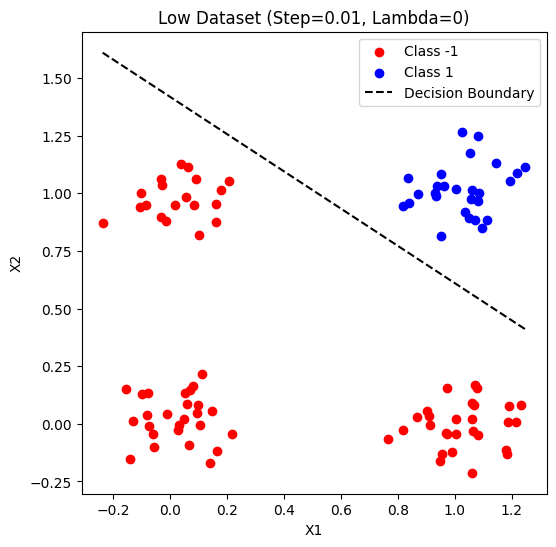

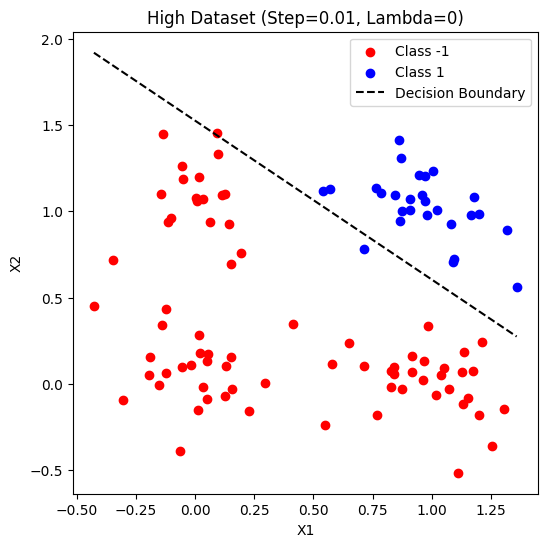

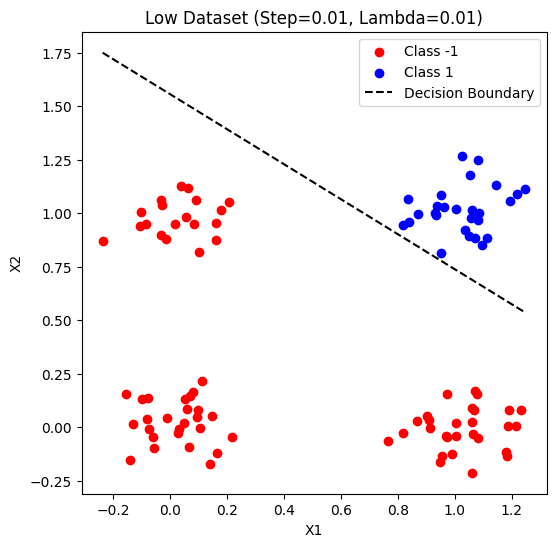

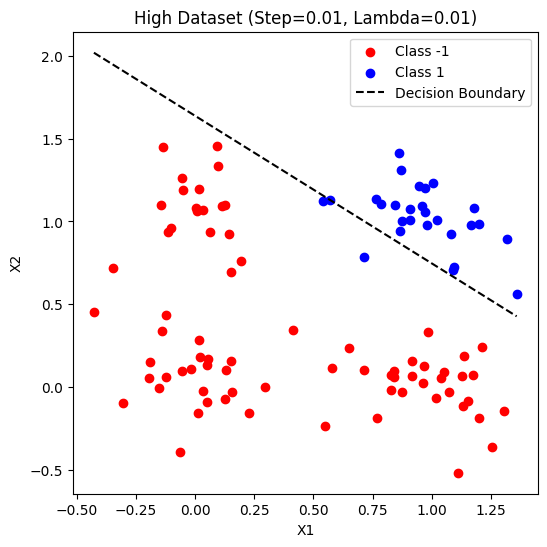

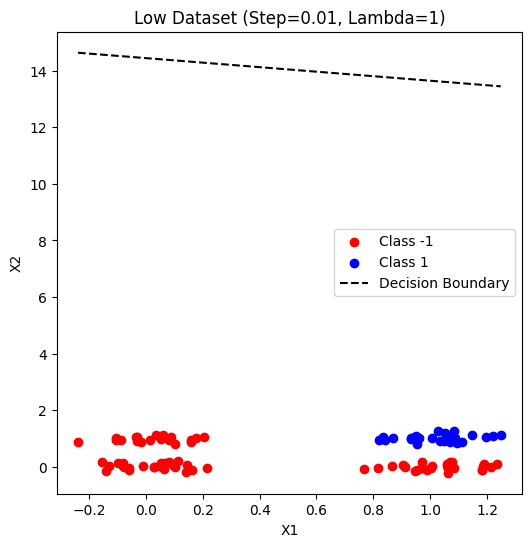

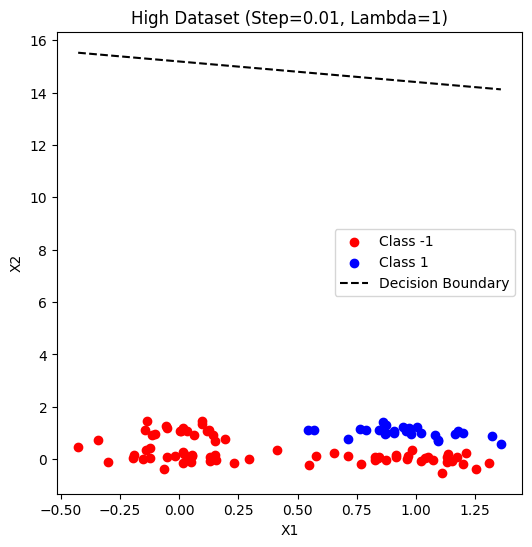

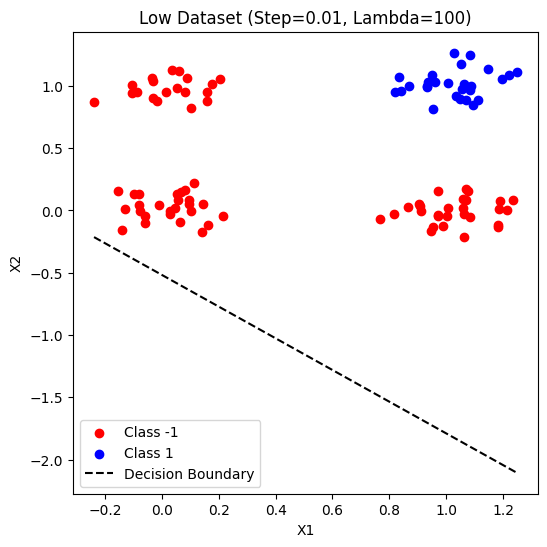

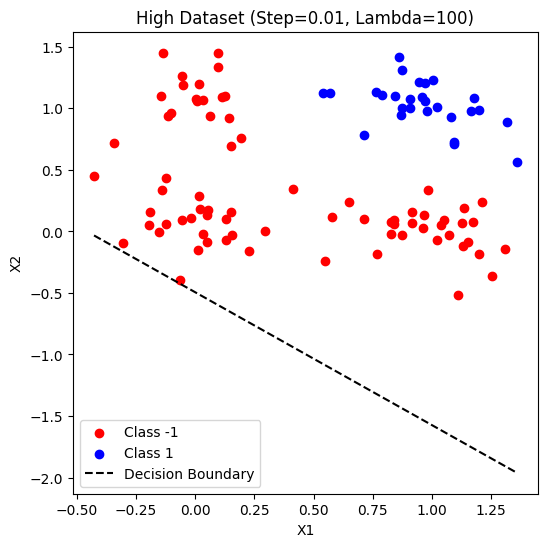

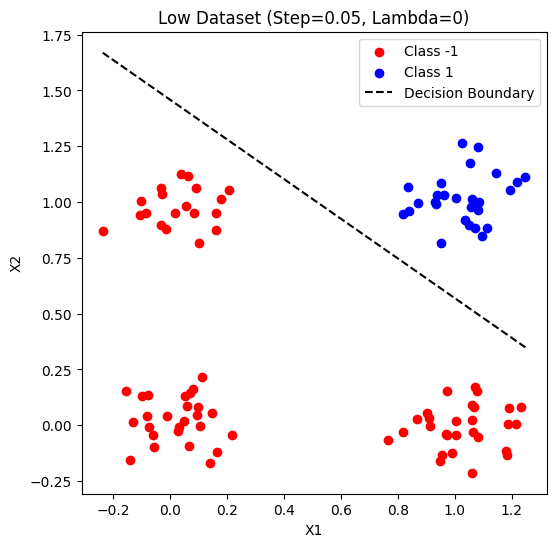

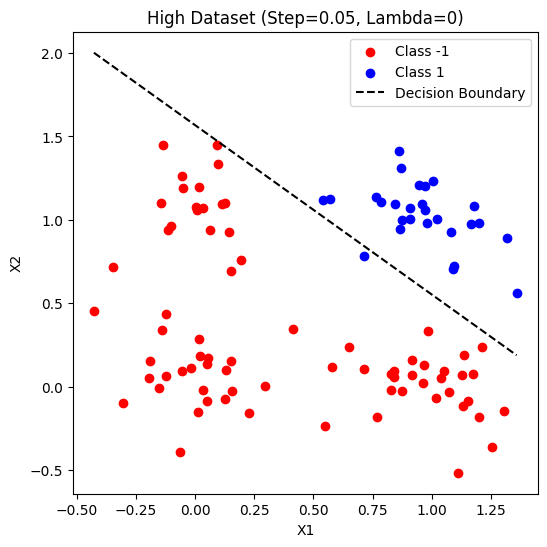

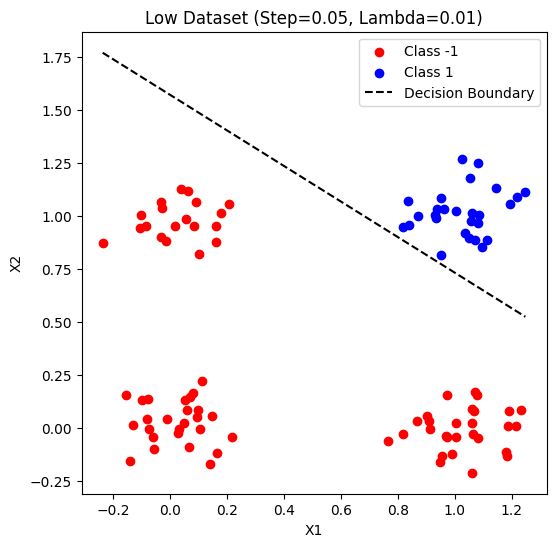

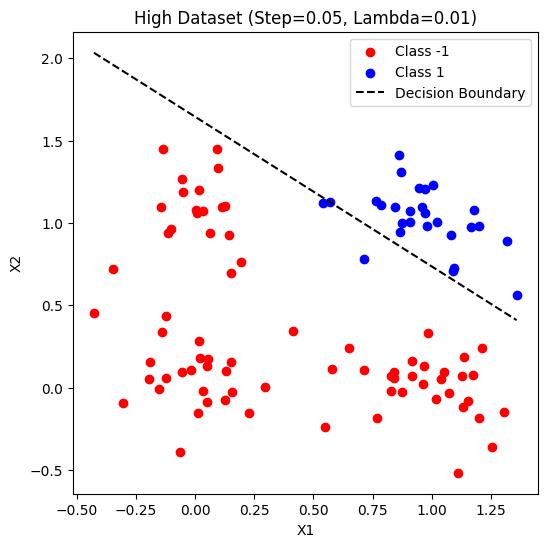

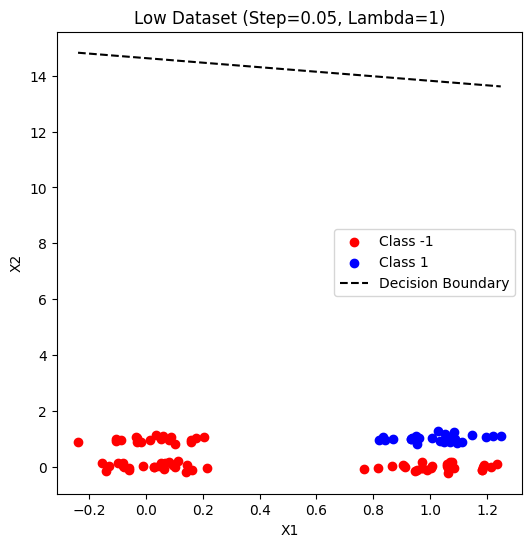

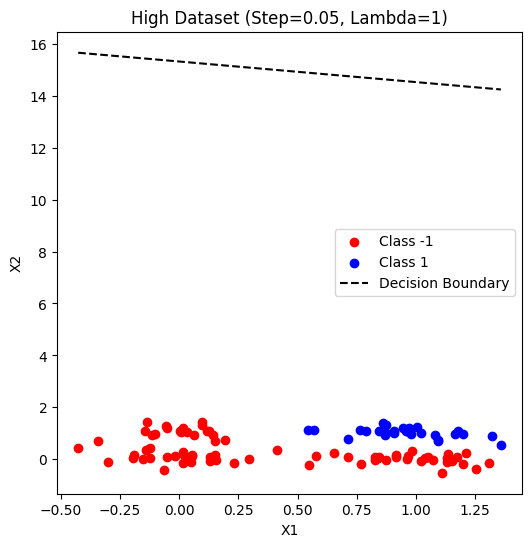

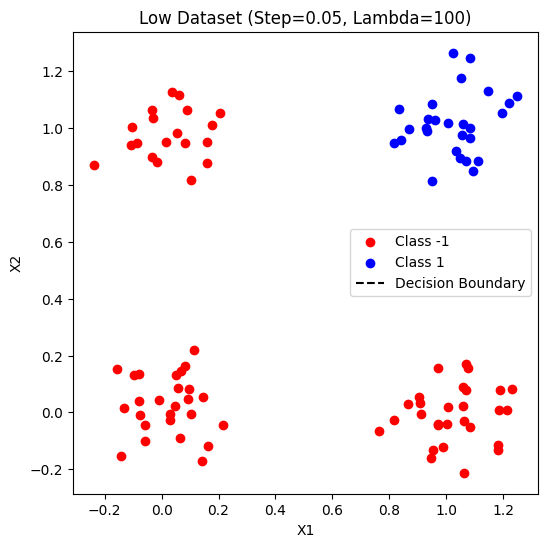

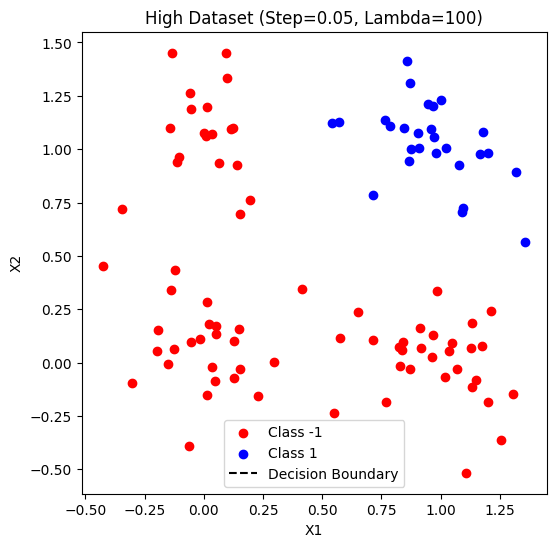

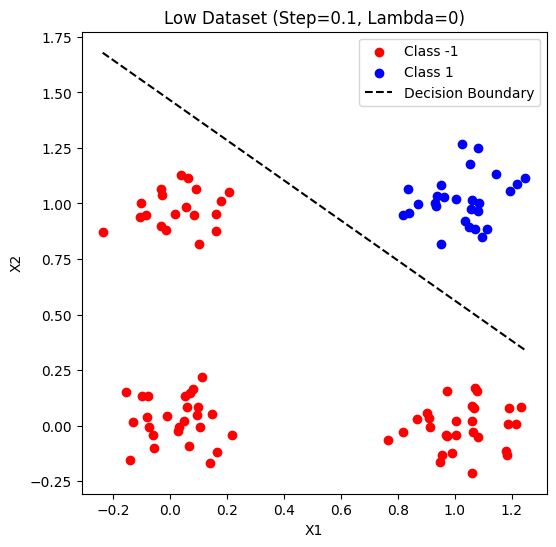

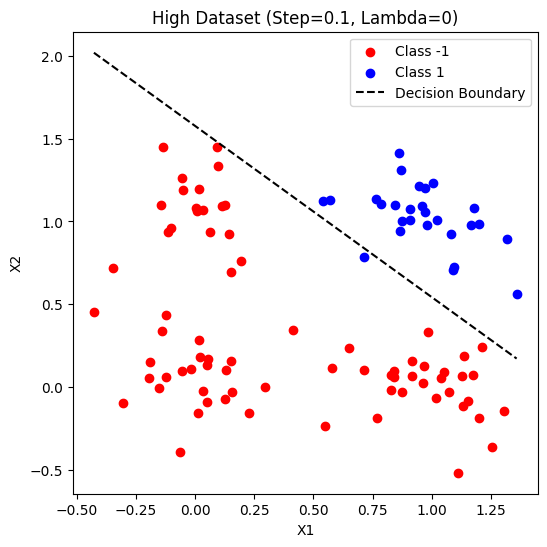

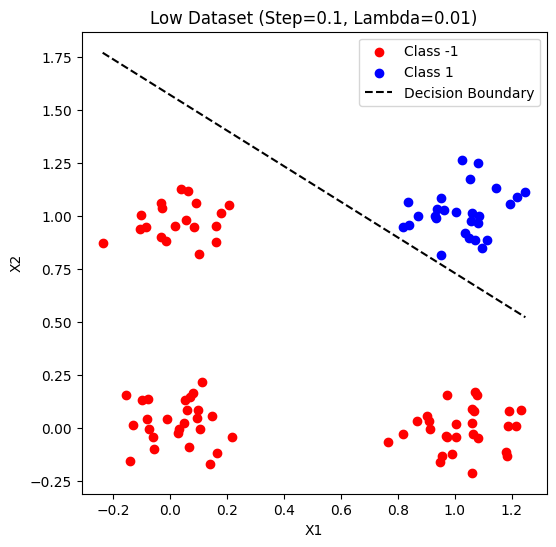

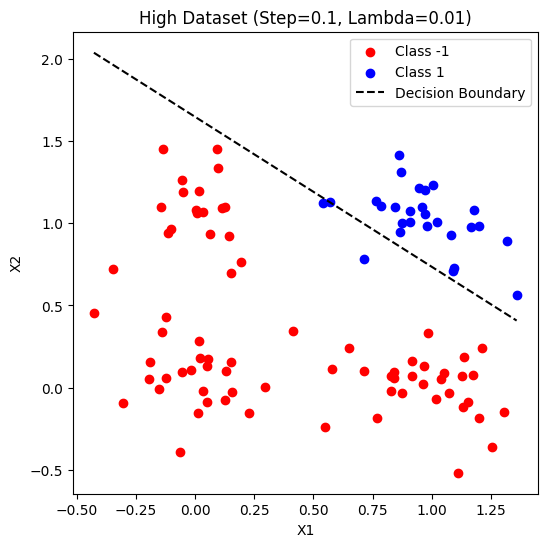

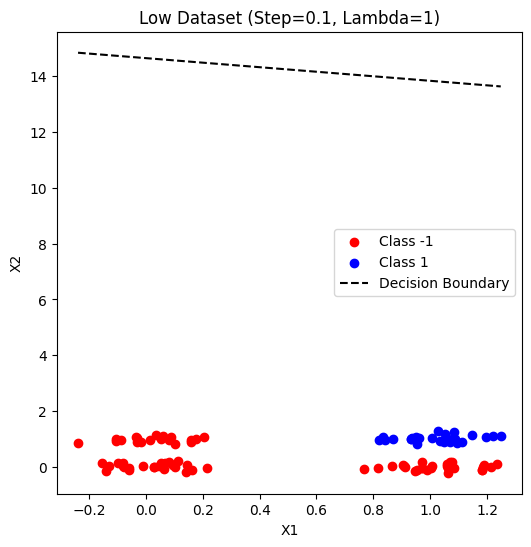

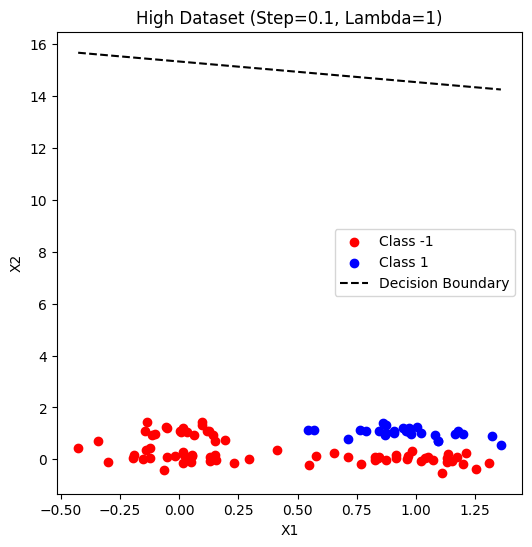

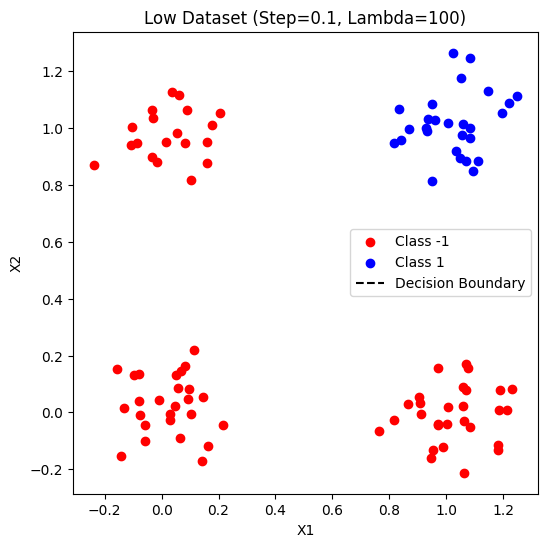

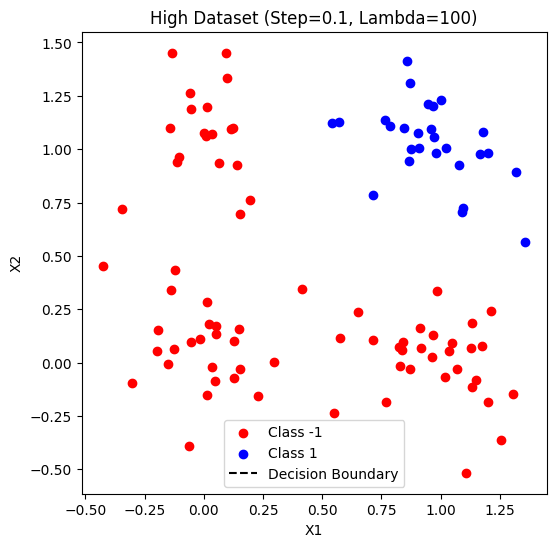

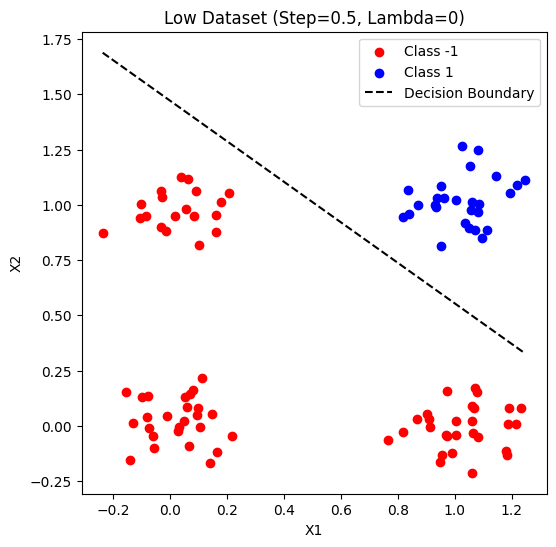

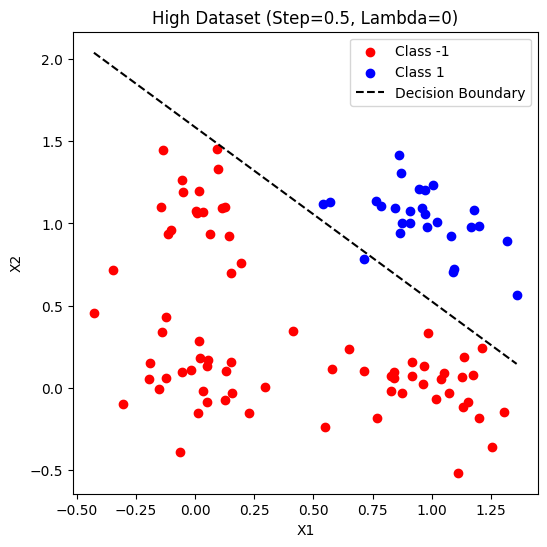

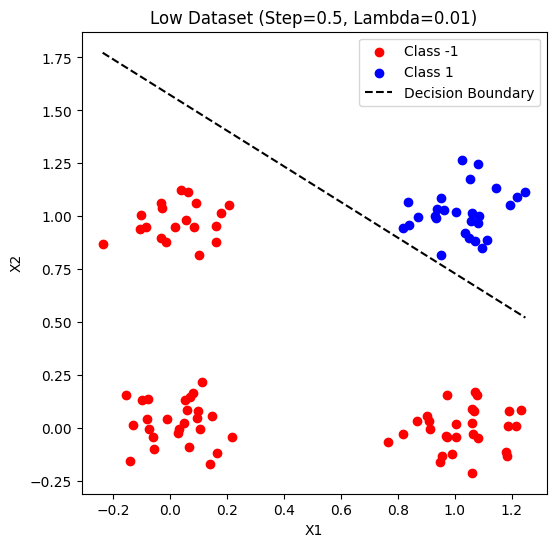

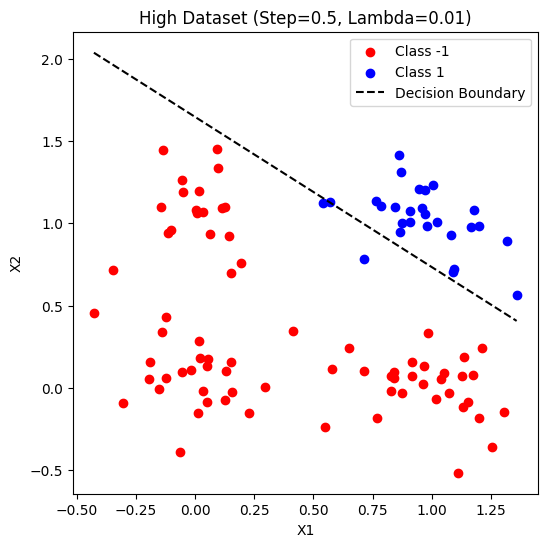

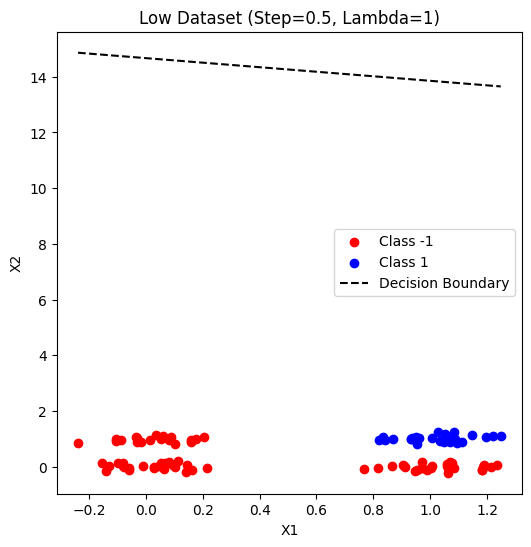

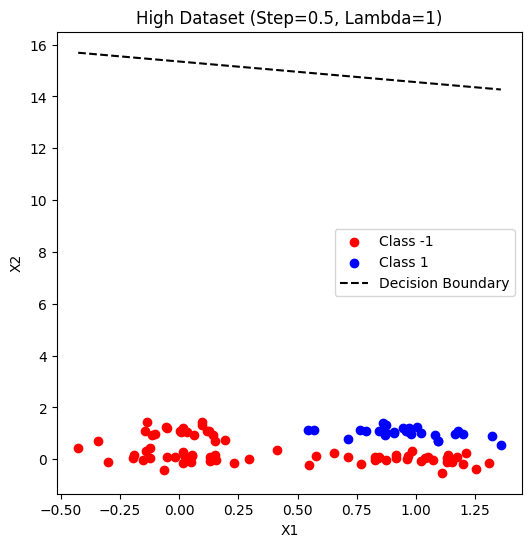

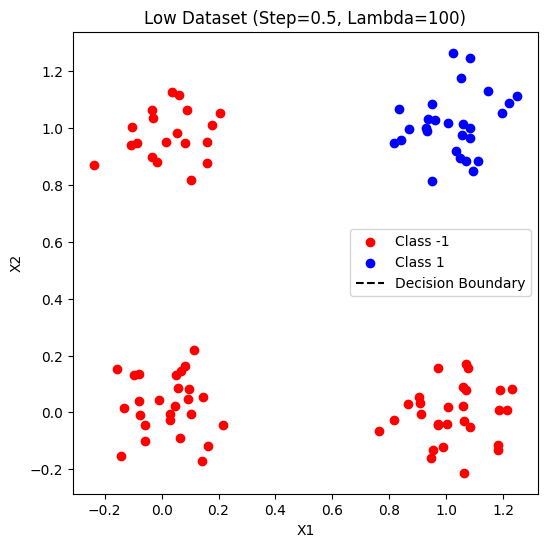

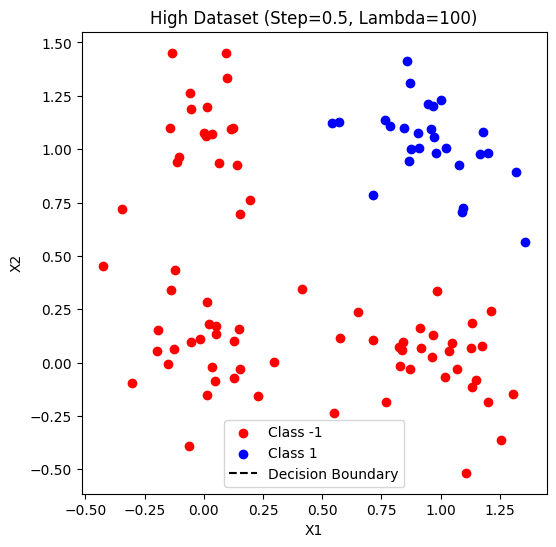

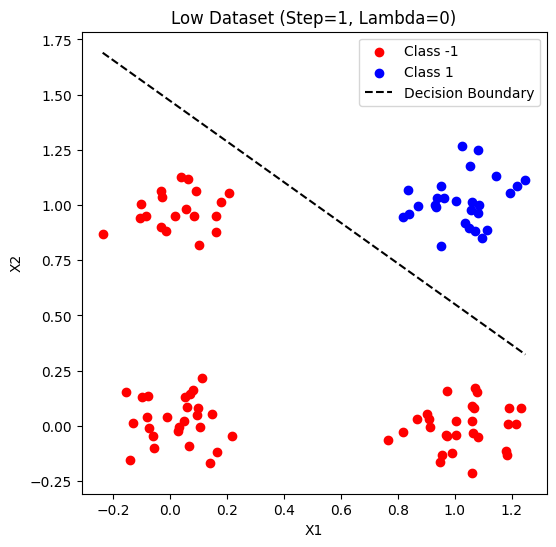

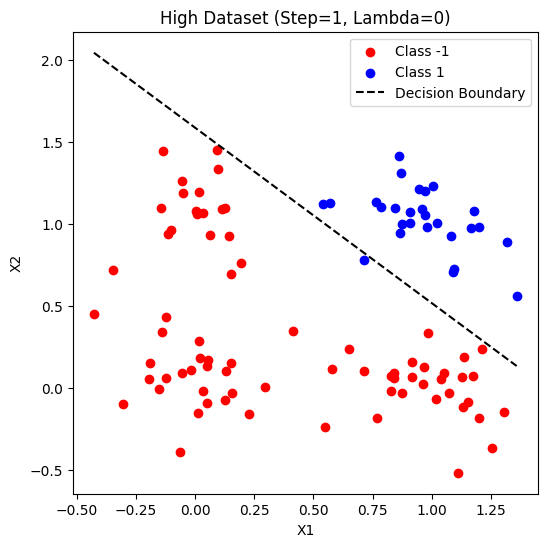

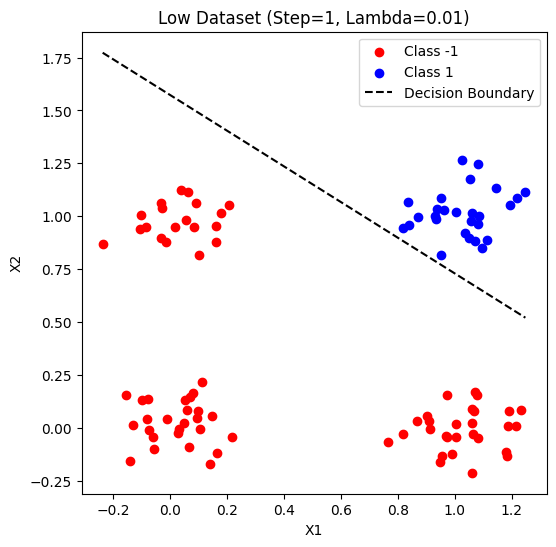

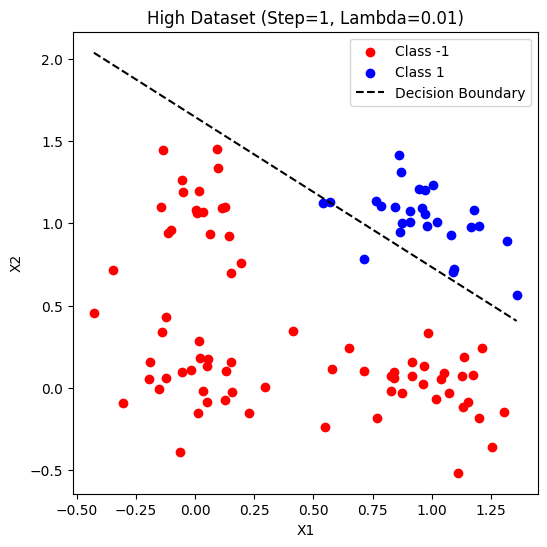

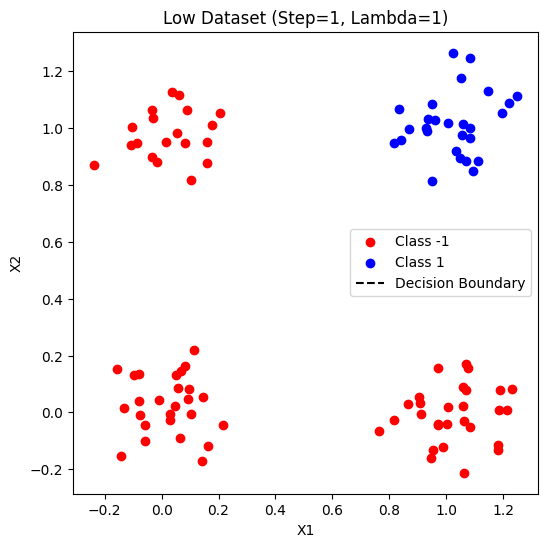

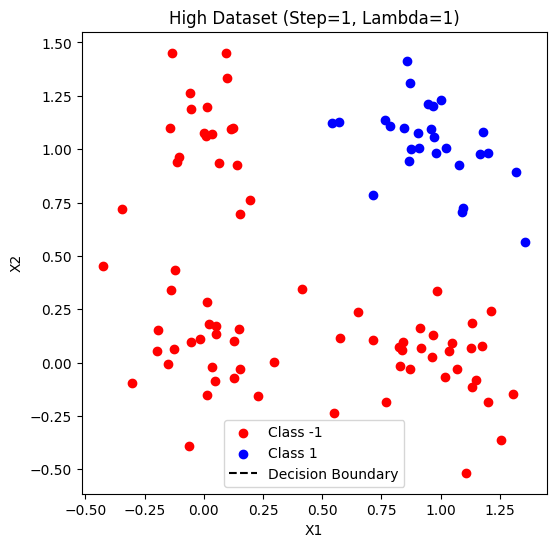

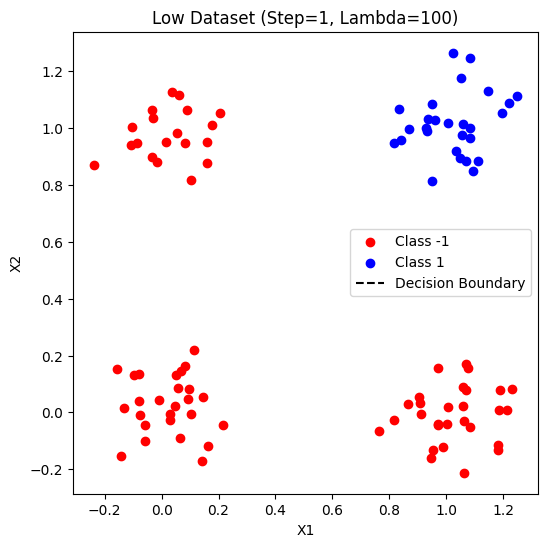

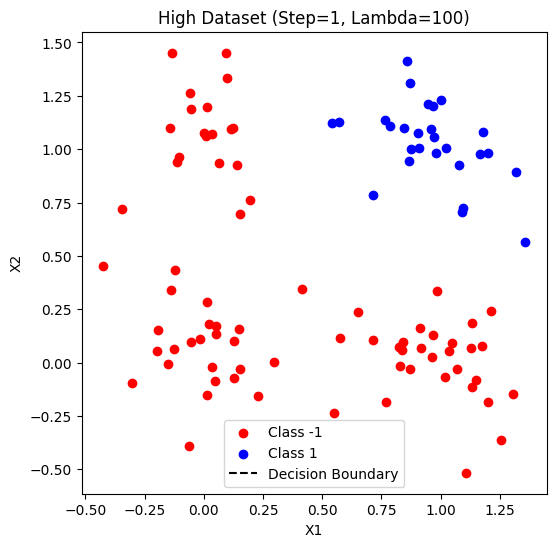

Iterations until convergence: {('low', 0.01, 0): 10000, ('high', 0.01, 0): 10000, ('low', 0.01, 0.01): 9700, ('high', 0.01, 0.01): 9719, ('low', 0.01, 1): 1522, ('high', 0.01, 1): 1520, ('low', 0.01, 100): 10000, ('high', 0.01, 100): 10000, ('low', 0.05, 0): 10000, ('high', 0.05, 0): 10000, ('low', 0.05, 0.01): 3541, ('high', 0.05, 0.01): 3566, ('low', 0.05, 1): 475, ('high', 0.05, 1): 474, ('low', 0.05, 100): 10000, ('high', 0.05, 100): 10000, ('low', 0.1, 0): 10000, ('high', 0.1, 0): 10000, ('low', 0.1, 0.01): 2127, ('high', 0.1, 0.01): 2144, ('low', 0.1, 1): 274, ('high', 0.1, 1): 274, ('low', 0.1, 100): 10000, ('high', 0.1, 100): 10000, ('low', 0.5, 0): 10000, ('high', 0.5, 0): 10000, ('low', 0.5, 0.01): 591, ('high', 0.5, 0.01): 597, ('low', 0.5, 1): 70, ('high', 0.5, 1): 70, ('low', 0.5, 100): 10000, ('high', 0.5, 100): 10000, ('low', 1, 0): 10000, ('high', 1, 0): 10000, ('low', 1, 0.01): 331, ('high', 1, 0.01): 334, ('low', 1, 1): 10000, ('high', 1, 1): 10000, ('low', 1, 100): 1

In [ ]:
# Load datasets
X_low, y_low = load_data('/content/drive/MyDrive/Colab Notebooks/Assignments/PSL/easy.csv')
X_high, y_high = load_data('/content/drive/MyDrive/Colab Notebooks/Assignments/PSL/hard.csv')

# Parameters
step_sizes = [0.01, 0.05, 0.1, 0.5, 1]
lambdas = [0, 0.01, 1, 100]

# Store iteration counts and results
iterations_results = {}
classification_results = {}
hyperplane_margins = {}

def compute_margin(w):
    return 1 / torch.norm(w[:-1])

# Train, store iterations, and plot results
for step_size in step_sizes:
    for lambd in lambdas:
        w_low, iterations_low = gradient_descent(X_low, y_low, step_size, lambd, loss_type='logistic')
        iterations_results[("low", step_size, lambd)] = iterations_low
        classification_results[("low", step_size, lambd)] = (y_low * (X_low @ w_low[:-1] + w_low[-1]) > 0).all().item()
        hyperplane_margins[("low", step_size, lambd)] = compute_margin(w_low).item()
        plot_results(X_low, y_low, w_low, f'Low Dataset (Step={step_size}, Lambda={lambd})')

        w_high, iterations_high = gradient_descent(X_high, y_high, step_size, lambd, loss_type='logistic')
        iterations_results[("high", step_size, lambd)] = iterations_high
        classification_results[("high", step_size, lambd)] = (y_high * (X_high @ w_high[:-1] + w_high[-1]) > 0).all().item()
        hyperplane_margins[("high", step_size, lambd)] = compute_margin(w_high).item()
        plot_results(X_high, y_high, w_high, f'High Dataset (Step={step_size}, Lambda={lambd})')

print("Iterations until convergence:", iterations_results)
print("Perfect classification achieved:", classification_results)
print("Hyperplane margins:", hyperplane_margins)

In [ ]:
# Convert iterations results to CSV
iterations_df = pd.DataFrame.from_dict(iterations_results, orient='index', columns=['Iterations'])
iterations_df.index = iterations_df.index.map(lambda x: '_'.join(map(str, x)))  # Convert tuples to strings
iterations_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Assignments/PSL/iterations_results.csv')

# Convert classification results to CSV
classification_df = pd.DataFrame.from_dict(classification_results, orient='index', columns=['Perfect_Classification'])
classification_df.index = classification_df.index.map(lambda x: '_'.join(map(str, x)))
classification_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Assignments/PSL/classification_results.csv')

# Convert hyperplane margins to CSV
margins_df = pd.DataFrame.from_dict(hyperplane_margins, orient='index', columns=['Margin'])
margins_df.index = margins_df.index.map(lambda x: '_'.join(map(str, x)))
margins_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Assignments/PSL/hyperplane_margins.csv')

print("CSV files saved successfully!")

CSV files saved successfully!
